In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 460kB 50.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
!pip install textrank

  Created wheel for textrank: filename=textrank-0.1.0-cp36-none-any.whl size=3421 sha256=fe4d883ebc24a7c6582222ab73696c74f31c69fb17ad79c76c6718a6e0841a7b
  Stored in directory: /root/.cache/pip/wheels/64/25/bf/e1b2f46da8146fe46171099ac23f084c17b97c3088cf3f7065
Successfully built textrank


In [ ]:
# requirements
import json
import pandas as pd
import numpy as np
import re
import networkx
from konlpy.tag import Komoran
import textrank
import tqdm
import matplotlib.pyplot as plt

In [ ]:
################################# for word summarizer #################################
class KeywordSummarizer:

    def __init__(self, sents=None, tokenize=None, min_count=2,
        window=-1, min_cooccurrence=2, vocab_to_idx=None,
        df=0.85, max_iter=30, verbose=False):

        self.tokenize = tokenize
        self.min_count = min_count
        self.window = window
        self.min_cooccurrence = min_cooccurrence
        self.vocab_to_idx = vocab_to_idx
        self.df = df
        self.max_iter = max_iter
        self.verbose = verbose

        if sents is not None:
            self.train_textrank(sents)

    def train_textrank(self, sents, bias=None):
        g, self.idx_to_vocab = word_graph(sents,
            self.tokenize, self.min_count,self.window,
            self.min_cooccurrence, self.vocab_to_idx, self.verbose)
        self.R = pagerank(g, self.df, self.max_iter, bias).reshape(-1)
        if self.verbose:
            print('trained TextRank. n words = {}'.format(self.R.shape[0]))

    def keywords(self, topk=30):
        if not hasattr(self, 'R'):
            raise RuntimeError('Train textrank first or use summarize function')
        idxs = self.R.argsort()[-topk:]
        keywords = [(self.idx_to_vocab[idx], self.R[idx]) for idx in reversed(idxs)]
        return keywords

    def summarize(self, sents, topk=30):
        self.train_textrank(sents)
        return self.keywords(topk)

################################# common untils for keywords #################################
from collections import defaultdict
from scipy.sparse import csr_matrix
from collections import Counter
from scipy.sparse import csr_matrix
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
from gensim.models import word2vec

def word_graph(sents, tokenize=None, min_count=2, window=2,
    min_cooccurrence=2, vocab_to_idx=None, verbose=False):
    if vocab_to_idx is None:
        idx_to_vocab, vocab_to_idx = scan_vocabulary(sents, tokenize, min_count)
    else:
        idx_to_vocab = [vocab for vocab, _ in sorted(vocab_to_idx.items(), key=lambda x:x[1])]

    tokens = tokenize_sents(sents, tokenize)
    g = cooccurrence(tokens, vocab_to_idx, window, min_cooccurrence, verbose)
    return g, idx_to_vocab


def scan_vocabulary(sents, tokenize=None, min_count=2):
    counter = Counter(w for sent in sents for w in tokenize(sent))
    counter = {w:c for w,c in counter.items() if c >= min_count}
    idx_to_vocab = [w for w, _ in sorted(counter.items(), key=lambda x:-x[1])]
    vocab_to_idx = {vocab:idx for idx, vocab in enumerate(idx_to_vocab)}
    return idx_to_vocab, vocab_to_idx

def tokenize_sents(sents, tokenize):
    return [tokenize(sent) for sent in sents]
'''
def vectorize(tokens, vocab_to_idx):
    rows, cols, data = [], [], []
    for i, tokens_i in enumerate(tokens):
        for t, c in Counter(tokens_i).items():
            j = vocab_to_idx.get(t, -1)
            if j == -1:
                continue
            rows.append(i)
            cols.append(j)
            data.append(c)
    n_sents = len(tokens)
    n_terms = len(vocab_to_idx)
    x = csr_matrix((data, (rows, cols)), shape=(n_sents, n_terms))
    return x
'''
# vectorize방법으로 word2vec생각
def vectorizer(tokens, vocab_to_idx):
  # parameters 
  num_features = 128 
  min_word_count = 2
  num_workers = 4
  context = 2
  oversampling = 1e-3

  model = word2vec.Word2Vec(tokens, workers = num_workers, size = num_features, min_count = min_word_count, window = context, sample = oversampling)
  model.init_sims(replace = True)
  weight_embedding = model.wv.vectors
  return weight_embedding



def cooccurrence(tokens, vocab_to_idx, window=2, min_cooccurrence=2, verbose=False):
    counter = defaultdict(int)
    for s, tokens_i in enumerate(tokens):
        if verbose and s % 1000 == 0:
            print('\rword cooccurrence counting {}'.format(s), end='')
        vocabs = [vocab_to_idx[w] for w in tokens_i if w in vocab_to_idx]
        n = len(vocabs)
        for i, v in enumerate(vocabs):
            if window <= 0:
                b, e = 0, n
            else:
                b = max(0, i - window)
                e = min(i + window, n)
            for j in range(b, e):
                if i == j:
                    continue
                counter[(v, vocabs[j])] += 1
                counter[(vocabs[j], v)] += 1
    counter = {k:v for k,v in counter.items() if v >= min_cooccurrence}
    n_vocabs = len(vocab_to_idx)
    if verbose:
        print('\rword cooccurrence counting from {} sents was done'.format(s+1))
    return dict_to_mat(counter, n_vocabs, n_vocabs)

def dict_to_mat(d, n_rows, n_cols):
    rows, cols, data = [], [], []
    for (i, j), v in d.items():
        rows.append(i)
        cols.append(j)
        data.append(v)
    return csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols))

################################# for sentecne summarizer #################################

class KeysentenceSummarizer:

    def __init__(self, sents=None, tokenize=None, min_count=2,
        min_sim=0.3, similarity=None, vocab_to_idx=None,
        df=0.85, max_iter=30, verbose=False):

        self.tokenize = tokenize
        self.min_count = min_count
        self.min_sim = min_sim
        self.similarity = similarity
        self.vocab_to_idx = vocab_to_idx
        self.df = df
        self.max_iter = max_iter
        self.verbose = verbose

        if sents is not None:
            self.train_textrank(sents)

    def train_textrank(self, sents, bias=None):
        g = sent_graph(sents, self.tokenize, self.min_count,
            self.min_sim, self.similarity, self.vocab_to_idx, self.verbose)
        self.R = pagerank(g, self.df, self.max_iter, bias).reshape(-1)
        if self.verbose:
            print('trained TextRank. n sentences = {}'.format(self.R.shape[0]))

    def summarize(self, sents, topk=30, bias=None):
        n_sents = len(sents)
        if isinstance(bias, np.ndarray):
            if bias.shape != (n_sents,):
                raise ValueError('The shape of bias must be (n_sents,) but {}'.format(bias.shape))
        elif bias is not None:
            raise ValueError('The type of bias must be None or numpy.ndarray but the type is {}'.format(type(bias)))

        self.train_textrank(sents, bias)
        idxs = self.R.argsort()[-topk:]
        keysents = [(idx, self.R[idx], sents[idx]) for idx in reversed(idxs)]
        return keysents

################################# common untils for keywords #################################
from collections import Counter
import math
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances



def sent_graph(sents, tokenize=None, min_count=2, min_sim=0.3,
    similarity=None, vocab_to_idx=None, verbose=False):

    if vocab_to_idx is None:
        idx_to_vocab, vocab_to_idx = scan_vocabulary(sents, tokenize, min_count)
    else:
        idx_to_vocab = [vocab for vocab, _ in sorted(vocab_to_idx.items(), key=lambda x:x[1])]

    x = vectorize_sents(sents, tokenize, vocab_to_idx)
    if similarity == 'cosine':
        x = numpy_cosine_similarity_matrix(x, min_sim, verbose, batch_size=1000)
    else:
        x = numpy_textrank_similarity_matrix(x, min_sim, verbose, batch_size=1000)
    return x

def vectorize_sents(sents, tokenize, vocab_to_idx):
    rows, cols, data = [], [], []
    for i, sent in enumerate(sents):
        counter = Counter(tokenize(sent))
        for token, count in counter.items():
            j = vocab_to_idx.get(token, -1)
            if j == -1:
                continue
            rows.append(i)
            cols.append(j)
            data.append(count)
    n_rows = len(sents)
    n_cols = len(vocab_to_idx)
    return csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols))

def numpy_cosine_similarity_matrix(x, min_sim=0.3, verbose=True, batch_size=1000):
    n_rows = x.shape[0]
    mat = []
    for bidx in range(math.ceil(n_rows / batch_size)):
        b = int(bidx * batch_size)
        e = min(n_rows, int((bidx+1) * batch_size))
        psim = 1 - pairwise_distances(x[b:e], x, metric='cosine')
        rows, cols = np.where(psim >= min_sim)
        data = psim[rows, cols]
        mat.append(csr_matrix((data, (rows, cols)), shape=(e-b, n_rows)))
        if verbose:
            print('\rcalculating cosine sentence similarity {} / {}'.format(b, n_rows), end='')
    mat = sp.sparse.vstack(mat)
    if verbose:
        print('\rcalculating cosine sentence similarity was done with {} sents'.format(n_rows))
    return mat

def numpy_textrank_similarity_matrix(x, min_sim=0.3, verbose=True, min_length=1, batch_size=1000):
    n_rows, n_cols = x.shape

    # Boolean matrix
    rows, cols = x.nonzero()
    data = np.ones(rows.shape[0])
    z = csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols))

    # Inverse sentence length
    size = np.asarray(x.sum(axis=1)).reshape(-1)
    size[np.where(size <= min_length)] = 10000
    size = np.log(size)

    mat = []
    for bidx in range(math.ceil(n_rows / batch_size)):

        # slicing
        b = int(bidx * batch_size)
        e = min(n_rows, int((bidx+1) * batch_size))

        # dot product
        inner = z[b:e,:] * z.transpose()

        # sentence len[i,j] = size[i] + size[j]
        norm = size[b:e].reshape(-1,1) + size.reshape(1,-1)
        norm = norm ** (-1)
        norm[np.where(norm == np.inf)] = 0

        # normalize
        sim = inner.multiply(norm).tocsr()
        rows, cols = (sim >= min_sim).nonzero()
        data = np.asarray(sim[rows, cols]).reshape(-1)

        # append
        mat.append(csr_matrix((data, (rows, cols)), shape=(e-b, n_rows)))

        if verbose:
            print('\rcalculating textrank sentence similarity {} / {}'.format(b, n_rows), end='')

    mat = sp.sparse.vstack(mat)
    if verbose:
        print('\rcalculating textrank sentence similarity was done with {} sents'.format(n_rows))

    return mat

def graph_with_python_sim(tokens, verbose, similarity, min_sim):
    if similarity == 'cosine':
        similarity = cosine_sent_sim
    elif callable(similarity):
        similarity = similarity
    else:
        similarity = textrank_sent_sim

    rows, cols, data = [], [], []
    n_sents = len(tokens)
    for i, tokens_i in enumerate(tokens):
        if verbose and i % 1000 == 0:
            print('\rconstructing sentence graph {} / {} ...'.format(i, n_sents), end='')
        for j, tokens_j in enumerate(tokens):
            if i >= j:
                continue
            sim = similarity(tokens_i, tokens_j)
            if sim < min_sim:
                continue
            rows.append(i)
            cols.append(j)
            data.append(sim)
    if verbose:
        print('\rconstructing sentence graph was constructed from {} sents'.format(n_sents))
    return csr_matrix((data, (rows, cols)), shape=(n_sents, n_sents))

def textrank_sent_sim(s1, s2):
    n1 = len(s1)
    n2 = len(s2)
    if (n1 <= 1) or (n2 <= 1):
        return 0
    common = len(set(s1).intersection(set(s2)))
    base = math.log(n1) + math.log(n2)
    return common / base

def cosine_sent_sim(s1, s2):
    if (not s1) or (not s2):
        return 0

    s1 = Counter(s1)
    s2 = Counter(s2)
    norm1 = math.sqrt(sum(v ** 2 for v in s1.values()))
    norm2 = math.sqrt(sum(v ** 2 for v in s2.values()))
    prod = 0
    for k, v in s1.items():
        prod += v * s2.get(k, 0)
    return prod / (norm1 * norm2)

In [ ]:
################################# pagerankAbstract #################################
import numpy as np
from sklearn.preprocessing import normalize

def pagerank(x, df=0.85, max_iter=30, bias=None):

    assert 0 < df < 1

    # initialize
    #A = normalize(x, axis=0, norm='l1')
    A = normalize(x, axis=0, norm='l2')
    R = np.ones(A.shape[0]).reshape(-1,1)

    # check bias
    if bias is None:
        bias = (1 - df) * np.ones(A.shape[0]).reshape(-1,1)
    else:
        bias = bias.reshape(-1,1)
        bias = A.shape[0] * bias / bias.sum()
        assert bias.shape[0] == A.shape[0]
        bias = (1 - df) * bias

    # iteration
    for _ in range(max_iter):
        R = df * (A * R) + bias

    return R

In [ ]:
### new page rank 
def pagerank(G, bias=None, df=0.15,max_iter=50, converge_error=0.001,verbose=0):
    
    A, nodes = _normalize(G)
    N = len(nodes) # number of nodes
    sr = 1 - df # survival rate (1 -  damping factor)
    ir = 1 / N # initial rank

    # Initialization
    rank = {n:ir for n in nodes}

    # Initialization of bias
    if not bias:
        bias = {node:ir for node in nodes}

    # Iteration
    for _iter in range(1, max_iter + 1):
        rank_new = {}

        # t: to node, f: from node, w: weight
        for t in nodes:
            f_dict = A.get(t, {})
            rank_t = sum((w*rank[f] for f, w in f_dict.items())) if f_dict else 0
            rank_t = sr * rank_t + df * bias.get(t, 0)
            rank_new[t] = rank_t

        # convergence check
        diff = sum((abs(rank[n] - rank_new[n]) for n in nodes))
        if diff < converge_error:
            if verbose:
                print('Early stopped at iter = {}'.format(_iter))
            break

        if verbose:
            sum_ = sum(rank_new.values())
            print('Iteration = {}, diff = {}, sum = {}'.format(_iter, diff, sum_))

        rank = rank_new

    return rank


def _normalize(G):
    # Sum of outbound weight
    # t: to node, f: from node, w: weight
    W_sum = {}    
    for t, f_dict in G.items():
        for f, w in f_dict.items():
            W_sum[f] = W_sum.get(f, 0) + w
    A = {t:{f:w/W_sum[f] for f,w in f_dict.items()} for t, f_dict in G.items()}    
    nodes = set(G.keys())
    nodes.update(W_sum)
    return A, nodes

In [ ]:
# load data 
def load_jsonl(path):
    data=[]
    with open(path, 'r', encoding='utf-8') as reader:
        for line in reader:
            data.append(json.loads(line))
    return data

In [ ]:
# train data 
train_jsonl = load_jsonl("train.jsonl")
train_jsonl[0]

# test data 
data_jsonl = load_jsonl("extractive_test_v2.jsonl")
data_jsonl[0]

{'article_original': ['▲ 석문간척지 임차법인협의회가 한국농어촌공사 당진지사 앞에 공공비축벼 320t을 쌓아두고 시위를 벌이고 있다.',
  '석문간척지 임차법인협의회(이하 간척지협의회)가 농림축산식품부의 부당한 간척지 임대료 책정에 반발하며 지난달 30일 한국농어촌공사 당진지사 앞에 공공비축벼 320t을 쌓고 시위를 벌였다.',
  '43개 영농조합법인이 소속된 간척지협의회는 이번 벼 야적 시위를 통해 현재 1kg당 2100원으로 책정된 임대료를 현재 쌀 판매가격인 1300원대로 인하할 것을 요구하고 있다.',
  '이들은 지난 12월 7일 농림축산식품부에 탄원서를 제출했지만 “임대료 인하는 올해 이후에나 가능하다”고 통보받은 상황이다.',
  '게다가 임차법인들의 계약기간이 올해 만료되기 때문에 임대료를 인하해도 지난 2년 동안의 손실 보상은 받을 수 없는 상황이다.',
  '이에 간척지협의회는 계약기간을 2년 연장하고, 연장된 기간 동안 인하된 임대료를 적용해 지난 2년 간의 손실에 대해 보상할 것을 제안했다.',
  '더불어 요구사항이 받아들여지지 않을 경우 벼 야적시위를 시작한 날짜인 지난해 12월 30일자로 임대료를 벼로 납부하겠다는 입장이다.',
  '김재용 봉치영농조합법인 조합원은 “현재 한국농어촌공사의 답변을 기다리고 있다”며 “상황을 지켜본 뒤 추가적인 야적 시위 여부를 결정할 계획”이라고 말했다.',
  '이어 “법을 만들고 집행할 때 현실성 있게 만들어야 한다”며 “농민이 정부를 믿을 수 있도록 조속히 해결책을 마련해주길 바란다”고 덧붙였다.'],
 'id': '500733466',
 'media': '당진시대'}

In [ ]:
# train data to dataframe
train = pd.DataFrame(train_jsonl)
train.head()

# test data to dataframe
df = pd.DataFrame(data_jsonl)
df.head()

,media,id,article_original
0,당진시대,500733466,[▲ 석문간척지 임차법인협의회가 한국농어촌공사 당진지사 앞에 공공비축벼 320t을 ...
1,당진시대,500742482,"[신 벌떼해장국이 손님들의 성원에 보답하고자 24시간 영업을 재개한다., 또한 이와..."
2,당진시대,500742484,"[1년 전과 비교해 당진지역 휘발유 가격은 72원, 경유 가격은 103원 상승했다...."
3,당진시대,504213810,[어기구 국회의원이 천연가스의 안정적 수급을 위해 2020년 착공이 예정돼 있는 액...
4,당진시대,505279620,"[당진시정책자문위원회가 유명무실하다는 비판이 지속적으로 제기되고 있다., 민선6기가..."


In [ ]:
# check train data index
def check_train_index(train):
  train['index_dstn'] = ''
  
  for i in range(len(train)):
    index_list = list()
    sent_len = len(train['article_original'][i])
    for j in range(len(train['extractive'][i])):
      ind = train['extractive'][i][j]
      index_list.append(round(ind/sent_len,2))

    train['index_dstn'][i] = index_list

  return train

def get_idx_dist(train):
  index_dstn_list = list()
  for i in range(len(train)):
    for j in range(len(train['index_dstn'][i])):
      index_dstn_list.append(train['index_dstn'][i][j])
  
  return index_dstn_list

In [ ]:
train_idx_dstn = check_train_index(train)
train_idx_dstn.head()

,media,id,article_original,abstractive,extractive,index_dstn
0,당진시대,327827480,[당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,"[0, 1, 2]","[0.0, 0.11, 0.22]"
1,국제신문,339840364,[미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,"[0, 1, 3]","[0.0, 0.05, 0.14]"
2,기호일보,371071597,"[인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아, 국유지로...",16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,"[6, 7, 10]","[0.32, 0.37, 0.53]"
3,대구일보,354806783,[대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,"[1, 6, 4]","[0.1, 0.6, 0.4]"
4,대구신문,347022773,[국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,"[2, 3, 10]","[0.15, 0.23, 0.77]"


[0.0, 0.11, 0.22, 0.0, 0.05, 0.14]


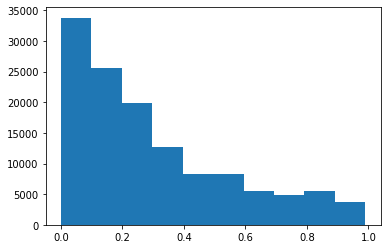

In [ ]:
index_dstn_list = get_idx_dist(train_idx_dstn)
print(index_dstn_list[:6])

## vis
plt.hist(index_dstn_list)
plt.show()

In [ ]:
# textRank
data = df.copy()

sents = data['article_original'][0]
print(sents)

['▲ 석문간척지 임차법인협의회가 한국농어촌공사 당진지사 앞에 공공비축벼 320t을 쌓아두고 시위를 벌이고 있다.', '석문간척지 임차법인협의회(이하 간척지협의회)가 농림축산식품부의 부당한 간척지 임대료 책정에 반발하며 지난달 30일 한국농어촌공사 당진지사 앞에 공공비축벼 320t을 쌓고 시위를 벌였다.', '43개 영농조합법인이 소속된 간척지협의회는 이번 벼 야적 시위를 통해 현재 1kg당 2100원으로 책정된 임대료를 현재 쌀 판매가격인 1300원대로 인하할 것을 요구하고 있다.', '이들은 지난 12월 7일 농림축산식품부에 탄원서를 제출했지만 “임대료 인하는 올해 이후에나 가능하다”고 통보받은 상황이다.', '게다가 임차법인들의 계약기간이 올해 만료되기 때문에 임대료를 인하해도 지난 2년 동안의 손실 보상은 받을 수 없는 상황이다.', '이에 간척지협의회는 계약기간을 2년 연장하고, 연장된 기간 동안 인하된 임대료를 적용해 지난 2년 간의 손실에 대해 보상할 것을 제안했다.', '더불어 요구사항이 받아들여지지 않을 경우 벼 야적시위를 시작한 날짜인 지난해 12월 30일자로 임대료를 벼로 납부하겠다는 입장이다.', '김재용 봉치영농조합법인 조합원은 “현재 한국농어촌공사의 답변을 기다리고 있다”며 “상황을 지켜본 뒤 추가적인 야적 시위 여부를 결정할 계획”이라고 말했다.', '이어 “법을 만들고 집행할 때 현실성 있게 만들어야 한다”며 “농민이 정부를 믿을 수 있도록 조속히 해결책을 마련해주길 바란다”고 덧붙였다.']


In [ ]:
# 단어 추출하여 열 생성 
data['token_pos'] = ''

komoran = Komoran()

def komoran_tokenize(sent):
  words = komoran.pos(sent, join = True)
  words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
  return words

for i in range(len(data)):
  data['token_pos'][i] = list()
  for j in range(len(data['article_original'][i])):
    data['token_pos'][i].append(komoran_tokenize(data['article_original'][i][j]))

print(data['token_pos'][0])

[['석문/NNP', '간척지/NNG', '임차/NNG', '법인/NNP', '협의회/NNG', '한국농어촌공사/NNP', '당진/NNP', '지사/NNP', '앞/NNG', '공공/NNG', '비축/NNG', '벼/NNG', '쌓/VV', '시위/NNG', '벌이/VV'], ['석문/NNP', '간척지/NNG', '임차/NNG', '법인/NNP', '협의회/NNG', '이하/NNP', '간척지/NNG', '협의회/NNG', '농림/NNP', '축산/NNP', '식품/NNG', '부/NNG', '부당/XR', '간척지/NNG', '임대료/NNG', '책정/NNG', '반발/NNG', '지난달/NNG', '일/NNB', '한국농어촌공사/NNP', '당진/NNP', '지사/NNP', '앞/NNG', '공공/NNG', '비축/NNG', '벼/NNG', '쌓/VV', '시위/NNG', '벌이/VV'], ['개/NNB', '영농/NNG', '조합/NNP', '법인/NNP', '소속/NNG', '간척지/NNG', '협의회/NNG', '이번/NNG', '벼/NNG', '야/NNG', '시위/NNG', '통하/VV', '당/NNP', '원/NNB', '책정/NNG', '임대료/NNG', '쌀/NNG', '판매/NNG', '가격/NNG', '원/NNB', '인하/NNG', '것/NNB', '요구/NNG'], ['지나/VV', '12월 7일/NNP', '농림/NNP', '축산/NNP', '식품/NNG', '부/NNG', '탄원서/NNG', '제출/NNG', '임대료/NNG', '인하/VV', '올해/NNG', '이후/NNG', '가능/XR', '통보/NNG', '받/VV', '상황/NNG'], ['임차/NNG', '법인/NNG', '계약/NNP', '기간/NNP', '올해/NNG', '만료/NNG', '때문/NNB', '임대료/NNG', '인하/NNG', '지나/VV', '년/NNB', '동안/NNG', '손실/NNP', '보상/NNG', '받/VV', '수/NNB', '없/V

In [ ]:
def pos_to_string(tmp_list):
  i_list = list()
  for i in range(len(tmp_list)):
    j_str = ''
    for j in range(len(tmp_list[i])):
      j_str = j_str + str(tmp_list[i][j]) + ' '
    i_list.append(j_str)
  return i_list

In [ ]:
data['token_str'] = data['token_pos'].map(pos_to_string)

In [ ]:
# check keywords 
keyword_extractor = KeywordSummarizer(
    tokenize = komoran_tokenize,
    #window = -1,
    window = 2, 
    verbose = True)

keywords = keyword_extractor.summarize(sents, topk=50)
for word, rank in keywords:
    print('{} ({:.3})'.format(word, rank))

word cooccurrence counting from 9 sents was done
trained TextRank. n words = 39
간척지/NNG (3.05e+16)
협의회/NNG (2.61e+16)
임대료/NNG (2.44e+16)
벼/NNG (1.86e+16)
법인/NNP (1.67e+16)
시위/NNG (1.54e+16)
한국농어촌공사/NNP (1.52e+16)
당진/NNP (1.3e+16)
책정/NNG (1.29e+16)
지사/NNP (1.26e+16)
임차/NNG (1.24e+16)
앞/NNG (1.2e+16)
공공/NNG (1.16e+16)
인하/NNG (1.14e+16)
년/NNB (1.1e+16)
비축/NNG (1.09e+16)
부/NNG (1.08e+16)
식품/NNG (1.07e+16)
축산/NNP (1.03e+16)
지나/VV (1.01e+16)
농림/NNP (9.91e+15)
원/NNB (9.71e+15)
쌓/VV (9.25e+15)
야/NNG (8.72e+15)
연장/NNG (8.54e+15)
기간/NNG (8.1e+15)
석문/NNP (7.77e+15)
상황/NNG (7.74e+15)
벌이/VV (7.55e+15)
동안/NNG (7.54e+15)


In [ ]:
## key sentence extract
summarizer = KeysentenceSummarizer(tokenize = komoran_tokenize, 
                                   min_sim = 0.7, 
                                   verbose = 1)

In [ ]:
# bias 설정 방법1
## 각 index별로 가중치 설정 : len(sents) = len(texts)
bias = np.ones(len(sents))

bias[0] = 7
bias[1] = 5
bias[2] = 4
bias[3] = 3
print(bias)

[7. 5. 4. 3. 1. 1. 1. 1. 1.]


In [ ]:
# sents 넣은 ver
def ext_keysentences_sents(sents, texts):
  ext_keysent = ''
  bias = np.ones(len(sents))
  bias[0] = 7
  bias[1] = 5
  bias[2] = 4
  bias[3] = 3
  keysents = summarizer.summarize(sents, bias = bias)

  for idx, rank, komoran_sent in keysents :
    ext_keysent = ext_keysent + str(texts[idx]) + '\n'
  return ext_keysent

def new_ext_keysentences_sents(sents, texts):
  ext_keysents = ''
  bias = np.zeros(len(sents))
  bias[0] = len(sents) / len(sents)
  bias[1] = (len(sents)-1) / len(sents)
  bias[2] = (len(sents)-2) / len(sents)
  bias[3] = (len(sents)-3)/ len(sents)
  keysents = summarizer.summarize(sents, bias = bias)

  for idx, rank, komoran_sent in keysents :
    ext_keysent = ext_keysent + str(texts[idx]) + '\n'
  return ext_keysent
  

In [ ]:
# texts 넣은 ver
def ext_keysentences_texts(sents, texts):
  ext_keysent = ''

  bias = np.ones(len(texts))
  bias[0] = 7
  bias[1] = 5
  bias[2] = 4
  bias[3] = 3
  keysents = summarizer.summarize(texts, bias = bias)

  for idx, rank, komoran_sents in keysents :
    ext_keysent = ext_keysent + str(texts[idx]) + '\n'
  return ext_keysent

In [ ]:
# 학습
data['ext_keysent_sent']=''
data['ext_keysent_text']=''

for i in range(len(data)):
    data['ext_keysent_sent'][i] = ext_keysentences_sents(data['token_str'][i],data['article_original'][i])
    data['ext_keysent_text'][i] = ext_keysentences_texts(data['token_str'][i],data['article_original'][i])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
calculating textrank sentence similarity was done with 13 sents
trained TextRank. n sentences = 13
calculating textrank sentence similarity was done with 13 sents
trained TextRank. n sentences = 13
calculating textrank sentence similarity was done with 10 sents
trained TextRank. n sentences = 10
calculating textrank sentence similarity was done with 10 sents
trained TextRank. n sentences = 10
calculating textrank sentence similarity was done with 14 sents
trained TextRank. n sentences = 14
calculating textrank sentence similarity was done with 14 sents
trained TextRank. n sentences = 14
calculating textrank sentence similarity was done with 9 sents
trained TextRank. n sentences = 9
calculating textrank sentence similarity was done with 9 sents
trained TextRank. n sentences = 9
calculating textrank sentence similarity was done with 8 sents
trained TextRank. n sentences = 8
calculating textrank sentence similarity was done with 8 sents
trained TextRank

submission

In [ ]:
data['ext_keysent_sent_list']=''
data['ext_keysent_text_list']=''

for i in range(len(data)):
    data['ext_keysent_sent_list'][i] = str(data['ext_keysent_sent'][i]).split('\n')[:3]
    data['ext_keysent_text_list'][i] = str(data['ext_keysent_text'][i]).split('\n')[:3]

In [ ]:
for i in range(len(data)):
    data['ext_keysent_sent_list'][i] = data['ext_keysent_sent_list'][i][0] + "\n" + data['ext_keysent_sent_list'][i][1] + "\n" + data['ext_keysent_sent_list'][i][2]
    data['ext_keysent_text_list'][i] = data['ext_keysent_text_list'][i][0] + "\n" + data['ext_keysent_text_list'][i][1] + "\n" + data['ext_keysent_text_list'][i][2]

In [ ]:
sub_data_sent = data[['id','ext_keysent_sent_list']]
sub_data_text = data[['id','ext_keysent_text_list']]

In [ ]:
sub_data_sent.rename(columns={'ext_keysent_sent_list': 'summary'}, inplace=True)
sub_data_text.rename(columns={'ext_keysent_text_list': 'summary'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
sub_data_sent.to_csv('TextRank_sent_3.csv', encoding='utf-8-sig', index=False)
sub_data_text.to_csv('TextRank_text_3.csv', encoding='utf-8-sig', index=False)

안맞는 부분 확인 : train 으로 확인 